<a href="https://colab.research.google.com/github/Blurr99/tensorflow_deepLearning/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences, text or speech)

Another common term for NLP problems is sequence to sequence problems (seq2seq).

## Check for GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-df6bf92f-cacb-b40c-a7e1-b9c5ce3b5293)


## Getting helper function

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import a series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2024-02-20 04:49:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-20 04:49:02 (97.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get the  text dataset

The dataset that is going to be used in this notebook is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster).
> LINK: https://www.kaggle.com/competitions/nlp-getting-started

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip the data
unzip_data("nlp_getting_started.zip")

--2024-02-20 04:49:08--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 2607:f8b0:4023:c03::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2024-02-20 04:49:08 (135 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]



## Visualize the dataset

In [ ]:
import pandas as pd

train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df["text"][1]

'Forest fire near La Ronge Sask. Canada'

In [ ]:
# Shuffle the train dataset
train_df_shuffled = train_df.sample(frac = 1, random_state = 42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# Structure of the test dataset
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# Number of examples of each class
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# Number of total samples
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# Visualizing some random training examples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index : random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not a real disaster)")
  print(f"Text: \n{text}\n")
  print("---\n")

Target: 0 (not a real disaster)
Text: 
Roger Goodell's Fatal Mistake: Tom Brady An Innocent Man http://t.co/UCNcKrnLow

---

Target: 0 (not a real disaster)
Text: 
.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4

---

Target: 0 (not a real disaster)
Text: 
@BrandonMulcahy @fpine Here's the story http://t.co/TgXutUoyHl

---

Target: 1 (real disaster)
Text: 
Young dancer moves about 300 youth in attendance at the GMMBC Youth Explosion this past Saturday. Inspiring! http://t.co/TMmOrvxsWz

---

Target: 1 (real disaster)
Text: 
SpaceX Founder Musk: Structural Failure Took Down Falcon 9 http://t.co/LvIzO9CSSR

---



### Splitting the data into train and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences,  train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                             train_df_shuffled["target"].to_numpy(),
                                                                             test_size = 0.1,
                                                                             random_state = 42)

In [ ]:
# Checking the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
for i in range(11):
  print(f"{train_sentences[i], train_labels[i]}\n")

('@mogacola @zamtriossu i screamed after hitting tweet', 0)

('Imagine getting flattened by Kurt Zouma', 0)

('@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....', 1)

("@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet", 0)

('Somehow find you and I collide http://t.co/Ee8RpOahPk', 0)

('@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao', 1)

('destroy the free fandom honestly', 1)

('Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE', 0)

('@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.', 1)

('Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt', 1)

('Lava Dragon Breeder! I just bred a Lava Dragon in DragonVale!

## Converting text into numbers

When working with a text problem, one of the first things that needs to be done is to convert the text into numbers.

Ways to do this:
* Tokenization: direct mapping of token (a token can be a work or a character) to number.
* Embedding: create a matrix of feature vector of each token (the size of the feature vector can be defined and this embedidng can be learned).

### Text vectorization (tokenzation)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Using the default parameters
text_vectorization = TextVectorization(max_tokens = None,
                                       standardize = "lower_and_strip_punctuation",
                                       split = "whitespace",
                                       ngrams = None,
                                       output_mode = "int",
                                       output_sequence_length = None,
                                       pad_to_max_tokens = False)

In [ ]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
# Setting up TextVectorization variables
max_vocab_length = 10000 # max number of words in the vocabulary
max_length = 15 # max number of words the sequences will be

text_vectorization = TextVectorization(max_tokens = max_vocab_length,
                                       output_mode = "int",
                                       output_sequence_length = max_length)

In [ ]:
# Fit the text vectorizer to the training data
text_vectorization.adapt(train_sentences)

In [ ]:
# Create a sample sentence and vectorize it
sample_sentence = "Theres a flood at my street!"
text_vectorization([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,  17,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from the training data and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original Text: \n{random_sentence}\
      \n\n Vectorized Version: \n")
text_vectorization([random_sentence])

Original Text: 
I'm awful at painting.. why did I agree to do an A3 landscape in bloody oils of all paints ??      

 Vectorized Version: 



<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  32, 2186,   17, 2815,   91,  145,    8, 1331,    5,   68,   39,
           1, 5252,    4,  261]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorization.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an embedding using an Embedding Layer
Most important parameters:
* `input_dim` = the size of the vocabulary
* `output_dim` = the size of the output embedding vector, for e.g., a value of 100 would mean each token gets represented by a vector 100 long.
* `input_length` = length of sequences being passed to embedding layer.

In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length,
                             output_dim = 128,
                             embeddings_initializer = "uniform",
                             input_length = max_length,
                             )
embedding

In [ ]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original Text: \n {random_sentence}\
        \n\n Embedded Version: \n")

# Embed the random sentence into dense vectors of fixed size
sample_embed = embedding(text_vectorization([random_sentence]))
sample_embed

Original Text: 
 this is about to be a bomb ass firework picture http://t.co/lr4BTvuEoM        

 Embedded Version: 



<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00523932, -0.03772547, -0.04767262, ..., -0.02875663,
         -0.02041202,  0.02420417],
        [-0.00016909, -0.0418968 , -0.0444315 , ..., -0.04619812,
         -0.03843952, -0.0309157 ],
        [-0.01654409,  0.01404966, -0.01004831, ...,  0.02406291,
          0.00199614, -0.01266981],
        ...,
        [ 0.04053747,  0.04513217,  0.03193649, ..., -0.03861039,
          0.00243799,  0.02379228],
        [ 0.04053747,  0.04513217,  0.03193649, ..., -0.03861039,
          0.00243799,  0.02379228],
        [ 0.04053747,  0.04513217,  0.03193649, ..., -0.03861039,
          0.00243799,  0.02379228]]], dtype=float32)>

In [ ]:
# Checking out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.0350269 ,  0.04763344,  0.04934568,  0.0034021 ,  0.03701004,
        -0.04460923, -0.03470205,  0.03025014, -0.04959337,  0.04013282,
         0.01214186, -0.02739686,  0.00498893, -0.00905039,  0.01669471,
         0.03963857, -0.03075154, -0.00073842, -0.01363566, -0.02480757,
        -0.01684182,  0.0208205 , -0.00849099,  0.03930781, -0.01727662,
        -0.01563343, -0.0467287 , -0.00870993,  0.025607  , -0.03916845,
         0.01945375, -0.03604817,  0.02880149,  0.01160804, -0.04446768,
        -0.02362078,  0.03859422,  0.01201778, -0.00110849,  0.00805342,
        -0.03543192, -0.0373893 ,  0.01997868,  0.0027064 ,  0.01861105,
        -0.01578895, -0.01857527, -0.02942636, -0.0159477 ,  0.02946586,
         0.02896955,  0.04428423, -0.00286146,  0.01835997,  0.01665803,
         0.0400846 ,  0.03139669,  0.0209065 ,  0.02690455,  0.01836878,
        -0.03138734, -0.04929837,  0.01571831, -0.01214593, -0.0223027 ,
  

## Modelling a text dataset (running a series of experiments)

* Model 0: Naive Bayes (Baseline)
* Model 1: Feed forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D ConvolutionalNeural Network (CNN)
* Model 6: TensorFlow Hub pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as Model 6 with 10% of training data


Steps to approach:
* Create a model
* Build a model
* Fit a model
* Evaluate a model

### Model 0: Getting a baseline

Creating a baseline model so there's a benchmark for future experiments to build upon.

Using sklearn's Multinomial Naive Bayes for creating a baseline using the TF-IDF formula to convert the words to numbers

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluating the baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"The baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

The baseline model achieves an accuracy of: 79.27%


In [ ]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# Making predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for a model's experiments

Creating a function to compare a model's predictions with the turth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1 score

In [ ]:
def get_evaluation_dict(model):
  dict = {}
  y_preds = model.predict(val_sentences)
  dict["Accuracy"] = f"{accuracy_score(val_labels, y_preds)*100:.2f}%"
  dict["Precision"] = precision_score(val_labels, y_preds)
  dict["Recall"] = recall_score(val_labels, y_preds)
  dict["F1-score"] = f1_score(val_labels, y_preds)

  return dict

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
    Calculates model accuracy, precision, recall and f1-score for binary classification model.
  """

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall, f1-score using "weighted average"
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average = "weighted")
  model_results = {
      "Accuracy" : model_accuracy,
      "Precision" : model_precision,
      "Recall" : model_recall,
      "F1 score" : model_f1
  }

  return model_results

In [ ]:
baseline_results = calculate_results(val_labels, baseline_preds)
baseline_results

{'Accuracy': 79.26509186351706,
 'Precision': 0.8111390004213173,
 'Recall': 0.7926509186351706,
 'F1 score': 0.7862189758049549}

### Model 1: A simple dense model

In [ ]:
# Create a tensorboard callback
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [ ]:
# Build model with Functional API
from tensorflow.keras import layers

inputs = layers.Input(shape = (1,), dtype = tf.string)
x = text_vectorization(inputs)  # turn inuput text into numbers
x = embedding(x)  # create an embedding of the numebrized inputs
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name = "model_1_dense")

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [ ]:
# Compile the model
model_1.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
# Fit the model
model_1_history = model_1.fit(x = train_sentences,
                              y = train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                                                       experiment_name = "model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20240219-085911
Epoch 1/5
215/215 [==============================] - 20s 74ms/step - loss: 0.6150 - accuracy: 0.6920 - val_loss: 0.5390 - val_accuracy: 0.7507
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.4425 - accuracy: 0.8192 - val_loss: 0.4677 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3473 - accuracy: 0.8600 - val_loss: 0.4569 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2845 - accuracy: 0.8905 - val_loss: 0.4655 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2380 - accuracy: 0.9114 - val_loss: 0.4777 - val_accuracy: 0.7782


In [ ]:
# Checking the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4777 - accuracy: 0.7782


[0.4776516556739807, 0.778215229511261]

In [ ]:
# Making predictions and evaluating them
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 2ms/step


(762, 1)

In [ ]:
# Looking at a single prediction
model_1_pred_probs[0]

array([0.3805468], dtype=float32)

In [ ]:
#Looking at the first 10 predictions
model_1_pred_probs[:10]

array([[0.3805468 ],
       [0.83576655],
       [0.99774325],
       [0.12597875],
       [0.10358561],
       [0.9433119 ],
       [0.9286019 ],
       [0.9921393 ],
       [0.96620834],
       [0.28312448]], dtype=float32)

In [ ]:
# Convert model prediction probabilities to label formats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [ ]:
baseline_results

{'Accuracy': 79.26509186351706,
 'Precision': 0.8111390004213173,
 'Recall': 0.7926509186351706,
 'F1 score': 0.7862189758049549}

In [ ]:
# Calculating the model 1's results
model_1_results = calculate_results(val_labels, model_1_preds)
model_1_results

{'Accuracy': 77.82152230971128,
 'Precision': 0.7817665184655122,
 'Recall': 0.7782152230971129,
 'F1 score': 0.7754656354277033}

In [ ]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualize Learned embeddings

In [ ]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorization.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [ ]:
# Get the weight matrix of embedding layer
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights[0].shape)

(128,)


In [ ]:
# Create embedding files
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
# Download files from colab to upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model 2: LSTM

Structure of an RNN usually looks like:

``` Input (text) -> Tokenize -> Embedding -> Layers (RNN/Dense) -> Output (label probability)```

In [ ]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape = (1,), dtype = tf.string)
x = text_vectorization(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units = 64, return_sequences = True)(x) # While stacking RNN cells together, return_sequences need to be True
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name = "model_2_LSTM")

In [ ]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
#Compile the model
model_2.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20240219-085957
Epoch 1/5
215/215 [==============================] - 11s 35ms/step - loss: 0.2178 - accuracy: 0.9254 - val_loss: 0.5651 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1562 - accuracy: 0.9418 - val_loss: 0.6753 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1276 - accuracy: 0.9550 - val_loss: 0.6531 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 2s 12ms/step - loss: 0.1035 - accuracy: 0.9597 - val_loss: 0.7266 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0867 - accuracy: 0.9672 - val_loss: 0.7967 - val_accuracy: 0.7717


In [ ]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[0.02599768],
       [0.8833593 ],
       [0.99970716],
       [0.07771336],
       [0.00155785],
       [0.99806565],
       [0.7181698 ],
       [0.9998234 ],
       [0.99963796],
       [0.43661162]], dtype=float32)

In [ ]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 2 results
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'Accuracy': 77.16535433070865,
 'Precision': 0.773559668677779,
 'Recall': 0.7716535433070866,
 'F1 score': 0.7694523344399302}

In [ ]:
baseline_results

{'Accuracy': 79.26509186351706,
 'Precision': 0.8111390004213173,
 'Recall': 0.7926509186351706,
 'F1 score': 0.7862189758049549}

### Model 3: GRU

GRU is another popular and effective RNN component. (also known as Gated Recurrent Unit).

The GRU cell has similar features to LSTM cell but has less parameters.

In [ ]:
# Creating model_3
inputs = layers.Input(shape = (1,), dtype = "string")
x = text_vectorization(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
# x = layers.GRU(units = 64, return_sequences = True)(x) # While stacking RNN cells together, return_sequences need to be True
# print(x.shape)
# x = layers.LSTM(42, return_sequences = True)(x)
# print(x.shape)
# x = layers.GRU(99)(x)
# print(x.shape)
# x = layers.Dense(64, activation = "relu")(x)
# x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name = "model_3_GRU")

In [ ]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [ ]:
# Compile the model
model_3.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20240219-090041
Epoch 1/5
215/215 [==============================] - 11s 41ms/step - loss: 0.1547 - accuracy: 0.9399 - val_loss: 0.7898 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0825 - accuracy: 0.9693 - val_loss: 0.8903 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0723 - accuracy: 0.9729 - val_loss: 0.9247 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0637 - accuracy: 0.9747 - val_loss: 1.0952 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0546 - accuracy: 0.9768 - val_loss: 1.2528 - val_accuracy: 0.7782


In [ ]:
# Making some predictions with model 3
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[4.97849716e-04],
       [8.51698875e-01],
       [9.99935031e-01],
       [8.50020051e-02],
       [1.11222405e-04],
       [9.99861121e-01],
       [8.84690702e-01],
       [9.99964952e-01],
       [9.99931455e-01],
       [9.98613715e-01]], dtype=float32)

In [ ]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate mdoel 3 results
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'Accuracy': 77.82152230971128,
 'Precision': 0.7796479981380524,
 'Recall': 0.7782152230971129,
 'F1 score': 0.7763875633348853}

### Model 4: Bidirectional

Normal RNN's go from left to right (just like an english sentence), however, a bidirectional RNN goes from left to right as well as from right to left.

In [ ]:
# Create model 4
from tensorflow.keras import layers
x = layers.Input(shape = (1,), dtype = "string")
x = text_vectorization(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences = True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name = "model_4_bidirectional")

In [ ]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [ ]:
# Compile the model
model_4.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20240219-090101
Epoch 1/5
215/215 [==============================] - 13s 42ms/step - loss: 0.1013 - accuracy: 0.9724 - val_loss: 0.9794 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0552 - accuracy: 0.9780 - val_loss: 1.1208 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0478 - accuracy: 0.9791 - val_loss: 1.2178 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0465 - accuracy: 0.9781 - val_loss: 1.3091 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0427 - accuracy: 0.9803 - val_loss: 1.1986 - val_accuracy: 0.7612


In [ ]:
# Making predictions on model 4
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


array([[9.9247687e-02],
       [9.2212003e-01],
       [9.9991667e-01],
       [1.1342701e-01],
       [7.1940558e-05],
       [9.9937916e-01],
       [8.0773932e-01],
       [9.9998391e-01],
       [9.9994445e-01],
       [9.9842787e-01]], dtype=float32)

In [ ]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculating model 4 results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'Accuracy': 76.11548556430446,
 'Precision': 0.7612627209133627,
 'Recall': 0.7611548556430446,
 'F1 score': 0.7598431815524319}

## Convolutional Neural Networks for Text

The typical structure of Conv1D model for sequences:
```
  Inputs(text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D or pooling) -> Outputs (class probabilities)
```

### Model 5: Conv1D

In [ ]:
# Testing out the embedding layer, Conv1D layer and the max pooling layer
from tensorflow.keras import layers
embedding_test = embedding(text_vectorization(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters = 32,
                        kernel_size = 5, # also referred to as an ngram of 5 (looks at 5 words at a time)
                        strides = 1,
                        activation = "relu",
                        padding = "valid")
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPooling1D()
max_pool_output = max_pool(conv_1d_output)

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [ ]:
# Create a 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape = (1,), dtype = tf.string)
x = text_vectorization(inputs)
x = embedding(x)
x = layers.Conv1D(filters = 64,
                  kernel_size = 5,
                  strides = 1,
                  activation = "relu",
                  padding = "valid")(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name = "model_5_conv1D")

# Compile the Conv1D model
model_5.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Summary of the model
model_5.summary()

Model: "model_5_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)              

In [ ]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20240219-090129
Epoch 1/5
215/215 [==============================] - 10s 38ms/step - loss: 0.1247 - accuracy: 0.9546 - val_loss: 0.9196 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0750 - accuracy: 0.9721 - val_loss: 1.0702 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0626 - accuracy: 0.9755 - val_loss: 1.1059 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0561 - accuracy: 0.9772 - val_loss: 1.2051 - val_accuracy: 0.7572
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0505 - accuracy: 0.9791 - val_loss: 1.2532 - val_accuracy: 0.7612


In [ ]:
# Making some predictions
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[1.3999943e-01],
       [9.7192818e-01],
       [9.9994516e-01],
       [4.8758712e-02],
       [2.7119063e-08],
       [9.9450433e-01],
       [7.8593647e-01],
       [9.9999225e-01],
       [9.9999940e-01],
       [9.7717834e-01]], dtype=float32)

In [ ]:
# Converting pred probs to preds
model_5_predictions = tf.squeeze(tf.round(model_5_pred_probs))
model_5_predictions[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Evaluate mode 5 predictions
model_5_results = calculate_results(val_labels, model_5_predictions)
model_5_results

{'Accuracy': 76.11548556430446,
 'Precision': 0.7615445184736523,
 'Recall': 0.7611548556430446,
 'F1 score': 0.7596168376680188}

In [ ]:
baseline_results

{'Accuracy': 79.26509186351706,
 'Precision': 0.8111390004213173,
 'Recall': 0.7926509186351706,
 'F1 score': 0.7862189758049549}

## Model 6: Tensorflow Hub Pretrained Sentence Encoder

Using transfer learning, specifically TensorFlow Hub's Universal Sentence Encoder: https://www.kaggle.com/models/google/universal-sentence-encoder

In [ ]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 45.3 MB/s eta 0:00:00


In [ ]:
sample_sentence

'Theres a flood at my street!'

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as text

english_sentences = tf.constant([sample_sentence, "When the universal sentence encoder is called on a sentence, it turns it into numbers."])

preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/cmlm-en-base/versions/1")

english_embeds = encoder(preprocessor(english_sentences))["default"]

print (english_embeds[0][:50])

tf.Tensor(
[ 0.0248296  -0.03637185  0.04463828 -0.11526786  0.10707054 -0.00070173
 -0.0989859  -0.05026377  0.08818121  0.00720744  0.1009884  -0.10928837
  0.03227057  0.00738077 -0.04685839  0.06913014 -0.08000515  0.06578954
 -0.06255247 -0.03652623  0.0235874   0.00640677 -0.17568503  0.08474603
  0.03024769 -0.06156315 -0.01483053  0.07346989  0.01629649 -0.03841049
 -0.02170764 -0.17450276 -0.14372426  0.01268796 -0.18157813 -0.01743637
 -0.02416911  0.05488009 -0.00423118 -0.00302255  0.02020528 -0.06483547
 -0.0756525   0.07647108  0.01962425 -0.02268834  0.09726764 -0.04308834
  0.08747728 -0.05536968], shape=(50,), dtype=float32)


In [ ]:
english_embeds[0].shape

TensorShape([768])

In [ ]:
# Create a Keras layer using the USE pretrained layer from Kaggle
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.00438637  0.02435914  0.02274885 -0.0141593   0.02424628  0.0889047
  0.02888083  0.06567273 -0.00610242 -0.00664645  0.00411185  0.00201372
 -0.02119484  0.09455124  0.06445288 -0.04171616  0.01693997 -0.04375052
 -0.00695595 -0.08056634 -0.05382917  0.02640241  0.0149875   0.01279173
 -0.01601805 -0.06174997  0.03324892 -0.00981064 -0.0380497  -0.01027906
 -0.0378894   0.06094595 -0.03173684  0.0007248   0.03728033 -0.06037606
  0.01713017  0.02897402  0.0068134  -0.09162798  0.02461487 -0.00304058
 -0.01315405  0.05872618 -0.10164236 -0.03168903  0.0131347  -0.01563225
 -0.03587101  0.03673211], shape=(50,), dtype=float32)


In [ ]:
embed_samples[0].shape

TensorShape([512])

In [ ]:
import tensorflow as tf

In [ ]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(128, activation="relu"),
  layers.Dense(64, activation = "relu"),
  layers.Dense(1, activation="sigmoid", name = "output_layer")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256871809 (979.89 MB)
Trainable params: 73985 (289.00 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Training the model
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20240219-090336
Epoch 1/5
215/215 [==============================] - 7s 14ms/step - loss: 0.4733 - accuracy: 0.7884 - val_loss: 0.4396 - val_accuracy: 0.8071
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3949 - accuracy: 0.8286 - val_loss: 0.4234 - val_accuracy: 0.8150
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3660 - accuracy: 0.8437 - val_loss: 0.4112 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3345 - accuracy: 0.8608 - val_loss: 0.4341 - val_accuracy: 0.8176
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2923 - accuracy: 0.8835 - val_loss: 0.4512 - val_accuracy: 0.8281


In [ ]:
# Make predictions with USE TF Hub
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 24ms/step


array([[0.07147994],
       [0.7978028 ],
       [0.9997229 ],
       [0.16383699],
       [0.611284  ],
       [0.9436232 ],
       [0.9961588 ],
       [0.99917716],
       [0.99736845],
       [0.06414556]], dtype=float32)

In [ ]:
# Convert prediction probabilities to predicted classes
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 6 results
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'Accuracy': 82.80839895013123,
 'Precision': 0.8321679242685085,
 'Recall': 0.8280839895013123,
 'F1 score': 0.8262746345531319}

## Model 7: TF Hub pretrained USE but with 10% of the data
Transfer learning is really helpful with a small dataset. To see how model 6 performs with 10% of the data, replicating it and experimenting.

In [ ]:
# Create subsets of 10% of the training data
train_10_percent = train_df_shuffled[["text", "target"]].sample(frac = 0.1, random_state = 42)
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent = train_10_percent["target"].to_list()
len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

In [ ]:
# Checking the number of target classes
train_10_percent["target"].value_counts(), train_df_shuffled["target"].value_counts()

(0    413
 1    348
 Name: target, dtype: int64,
 0    4342
 1    3271
 Name: target, dtype: int64)

In [ ]:
# Creating model 7
# model_7 = tf.keras.models.clone_model(model_6)
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    # layers.Dense(128, activation = "relu"),
    layers.Dense(64, activation = "relu"),
    layers.Dense(1, activation = "sigmoid", name = "output_layer")
], name = "model_7_USE")

# Compile the model
model_7.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Summary of the model
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_8 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Fit the model
model_7_history = model_7.fit(train_10_percent,
                              train_labels_10_percent,
                              epochs = 5,
                              validation_data = (val_sentences,val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       "model_7_USE_correct_split")])

Saving TensorBoard log files to: model_logs/model_7_USE_correct_split/20240219-093447
Epoch 1/5
22/22 [==============================] - 2s 49ms/step - loss: 0.6763 - accuracy: 0.6628 - val_loss: 0.6510 - val_accuracy: 0.7612
Epoch 2/5
22/22 [==============================] - 1s 27ms/step - loss: 0.6105 - accuracy: 0.8000 - val_loss: 0.5958 - val_accuracy: 0.7677
Epoch 3/5
22/22 [==============================] - 0s 21ms/step - loss: 0.5369 - accuracy: 0.8131 - val_loss: 0.5407 - val_accuracy: 0.7769
Epoch 4/5
22/22 [==============================] - 0s 21ms/step - loss: 0.4747 - accuracy: 0.8146 - val_loss: 0.5036 - val_accuracy: 0.7782
Epoch 5/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4294 - accuracy: 0.8263 - val_loss: 0.4901 - val_accuracy: 0.7769


In [ ]:
# Making predictions with model 7
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.20878984],
       [0.5959316 ],
       [0.9154499 ],
       [0.36151952],
       [0.5476825 ],
       [0.7077107 ],
       [0.8778115 ],
       [0.8243677 ],
       [0.84349006],
       [0.1706455 ]], dtype=float32)

In [ ]:
# Converting prediction probabilities to predicted classes
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calucalting model 7 results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'Accuracy': 77.69028871391076,
 'Precision': 0.7779652793701148,
 'Recall': 0.7769028871391076,
 'F1 score': 0.7752416323647977}

In [ ]:
model_6_results

{'Accuracy': 82.80839895013123,
 'Precision': 0.8321679242685085,
 'Recall': 0.8280839895013123,
 'F1 score': 0.8262746345531319}

In [ ]:
# Making a better data split (with no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [ ]:
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

## Comparing the performance of each of the models

In [ ]:
# Combine all model results
all_model_results = pd.DataFrame({"0_baseline" : baseline_results,
                                  "1_simple_dense" : model_1_results,
                                  "2_LSTM": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional_LSTM": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.T

In [ ]:
all_model_results["Accuracy"] = all_model_results["Accuracy"]/100
all_model_results

,Accuracy,Precision,Recall,F1 score
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.778215,0.781767,0.778215,0.775466
2_LSTM,0.771654,0.773560,0.771654,0.769452
3_gru,0.778215,0.779648,0.778215,0.776388
4_bidirectional_LSTM,0.761155,0.761263,0.761155,0.759843
5_conv1d,0.761155,0.761545,0.761155,0.759617
6_tf_hub_use_encoder,0.828084,0.832168,0.828084,0.826275
7_tf_hub_use_encoder_10_percent,0.776903,0.777965,0.776903,0.775242


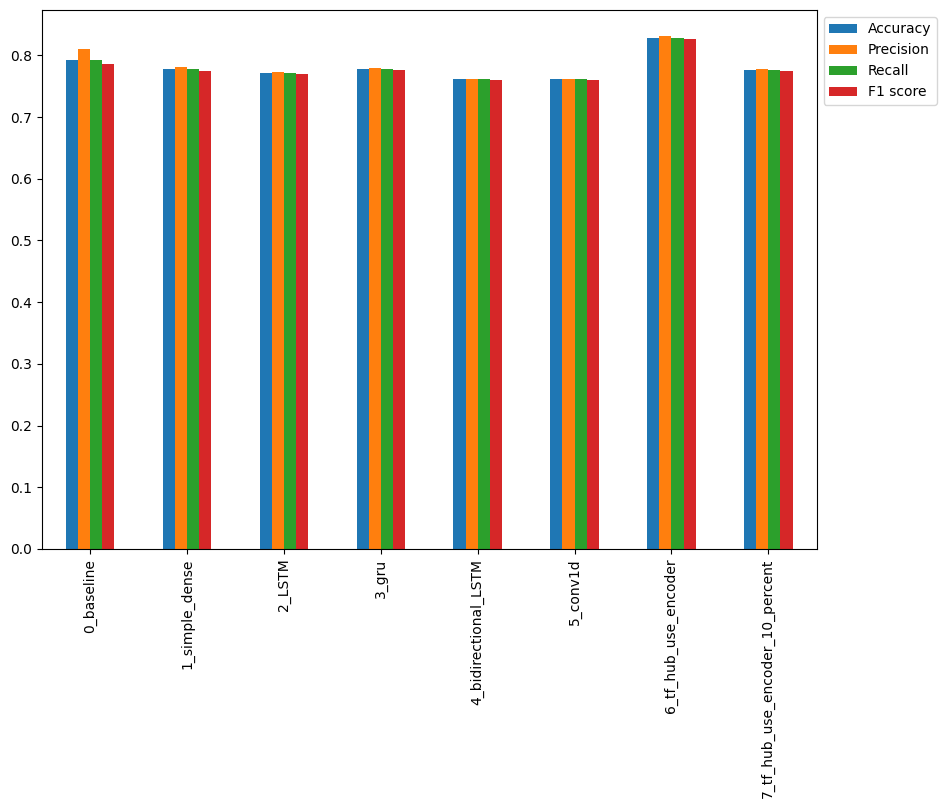

In [ ]:
# Plot and compare all model's results
all_model_results.plot(kind = "bar", figsize = (10,7)).legend(bbox_to_anchor = (1.0, 1.0));

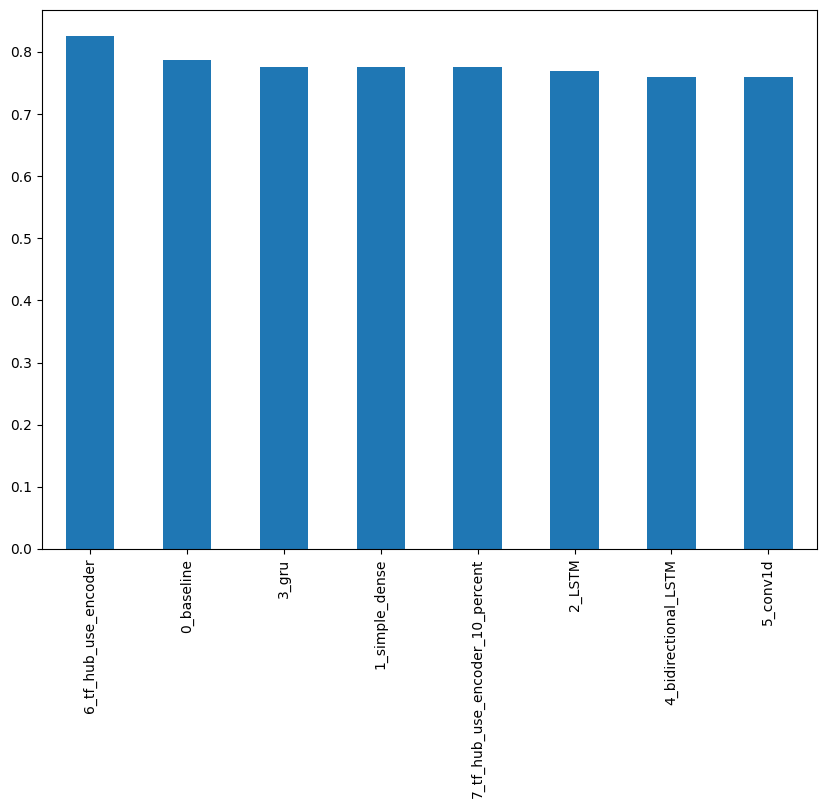

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values(by = "F1 score", ascending = False)["F1 score"].plot(kind = "bar", figsize = (10,7));

## Saving and loading a trained model

In [ ]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load model with custom Hub Layer (req when using HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects = {"KerasLayer": hub.KerasLayer})

In [ ]:
# Evaluating the loaded model
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 19ms/step - loss: 0.4512 - accuracy: 0.8281


[0.45119187235832214, 0.8280839920043945]

Saving to the `SavedModel` format

In [ ]:
# Save TH Hub Sentence Encoder Model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [ ]:
# Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [ ]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 31ms/step - loss: 0.4512 - accuracy: 0.8281


[0.45119187235832214, 0.8280839920043945]

In [ ]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256871809 (979.89 MB)
Trainable params: 73985 (289.00 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


## Finding the most wrong examples

In [ ]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2024-02-20 04:48:25--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  83.3MB/s    in 11s     

2024-02-20 04:48:36 (82.1 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables

In [ ]:
# Import previously trained model
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 9s 18ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [ ]:
# Make predictions using the pretrained model
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

24/24 [==============================] - 1s 9ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
tf.squeeze(val_sentences).shape

TensorShape([762])

In [ ]:
# Create DataFrame with validation sentences, labels and best performing model prediction labels + probabilities
val_df = pd.DataFrame({"text" : val_sentences,
                       "target" : val_labels,
                       "pred" : model_6_pretrained_preds,
                       "pred_prob" : tf.squeeze(model_6_pretrained_pred_probs)})

In [ ]:
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [ ]:
most_wrong = val_df[val_df["pred"] != val_df["target"]].sort_values(by = "pred_prob", ascending = False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [ ]:
most_wrong.tail()

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043919
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [ ]:
# Visualizing all the false positives
for row in most_wrong[:10].itertuples():
  _, txt, targ, predic, pred_proba = row
  print(f"Target: {targ}, Prediction: {predic}, Prediction Probability: {pred_proba}")
  print(f"Text: \n {txt}\n")
  print("----\n")

Target: 0, Prediction: 1.0, Prediction Probability: 0.9101957678794861
Text: 
 ? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Prediction: 1.0, Prediction Probability: 0.8769821524620056
Text: 
 FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Prediction: 1.0, Prediction Probability: 0.8523001074790955
Text: 
 @noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Prediction: 1.0, Prediction Probability: 0.8354543447494507
Text: 
 Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Prediction: 1.0, Prediction Probability: 0.8272132873535156
Text: 
 @AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred

In [ ]:
# Visualizing all the false negatives
for row in most_wrong[-10:].itertuples():
  _, txt, targ, predic, pred_proba = row
  print(f"Target: {targ}, Prediction: {predic}, Prediction Probability: {pred_proba}")
  print(f"Text: \n {txt}\n")
  print("----\n")

Target: 1, Prediction: 0.0, Prediction Probability: 0.06730346381664276
Text: 
 @DavidVonderhaar At least you were sincere ??

----

Target: 1, Prediction: 0.0, Prediction Probability: 0.05507583171129227
Text: 
 @willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Prediction: 0.0, Prediction Probability: 0.05460337549448013
Text: 
 Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Prediction: 0.0, Prediction Probability: 0.05459701269865036
Text: 
 going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Prediction: 0.0, Prediction Probability: 0.04963727295398712
Text: 
 You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Prediction: 0.0, Prediction Probabilit

In [ ]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


## Making predictions on the test dataset

In [ ]:
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)

for test_sample in test_samples:
  pred_proba = tf.squeeze(model_6_pretrained.predict([test_sample]))
  predic = tf.round(pred_proba)
  print(f"Pred: {int(predic)}, Prob: {pred_proba}")
  print(f"Text: \n{test_sample}")
  print("---\n")

1/1 [==============================] - 0s 33ms/step
Pred: 1, Prob: 0.9352068305015564
Text: 
India: Militant 'Overpowered' By Hostages After Attack http://t.co/mkjszGbaWR
---

1/1 [==============================] - 0s 36ms/step
Pred: 1, Prob: 0.9686601758003235
Text: 
Rare photographs show the nightmare aftermath of #Hiroshima | #NoNukes #Amerikkka #WhiteTerrorism #Nuclear #Disaster  http://t.co/8tWLAKdaBf
---

1/1 [==============================] - 0s 34ms/step
Pred: 0, Prob: 0.4745257794857025
Text: 
#LocalEventCountdown:
8. Curtain opens on The Black Cyclone in Shelby tickets &amp; info: http://t.co/v7dCz5DJDj #rstoday
---

1/1 [==============================] - 0s 33ms/step
Pred: 0, Prob: 0.46143704652786255
Text: 
Enter the world of extreme diving ÛÓ 9 stories up and into the Volga River http://t.co/gptysALfKi
---

1/1 [==============================] - 0s 33ms/step
Pred: 0, Prob: 0.05172423645853996
Text: 
Mental health is real..?? Self harm is real..??Depression is real..?? fee

## The Speed/Score tradeoff

In [ ]:
# Making a fucntion to measure the time of prediction
import time
def pred_timer(model,samples):
  """
    Times how long a model takes to make predictions on a sample.
  """
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time - start_time
  time_per_prediction = total_time / len(samples)

  return total_time, time_per_prediction

In [ ]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_time, model_6_time_per_pred = pred_timer(model_6_pretrained, val_sentences)
model_6_total_time, model_6_time_per_pred

24/24 [==============================] - 0s 8ms/step


(0.3570796399999381, 0.0004686084514434883)

In [ ]:
# Calculate thwe baseline model's time per pred
baseline_total_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_time, baseline_time_per_pred

(0.01549743799978387, 2.0337845144073318e-05)

In [ ]:
model_6_pretrained_results = calculate_results(val_labels, model_6_pretrained_preds)
model_6_pretrained_results

{'Accuracy': 81.62729658792651,
 'Precision': 0.818446310697231,
 'Recall': 0.8162729658792651,
 'F1 score': 0.8148082644367335}

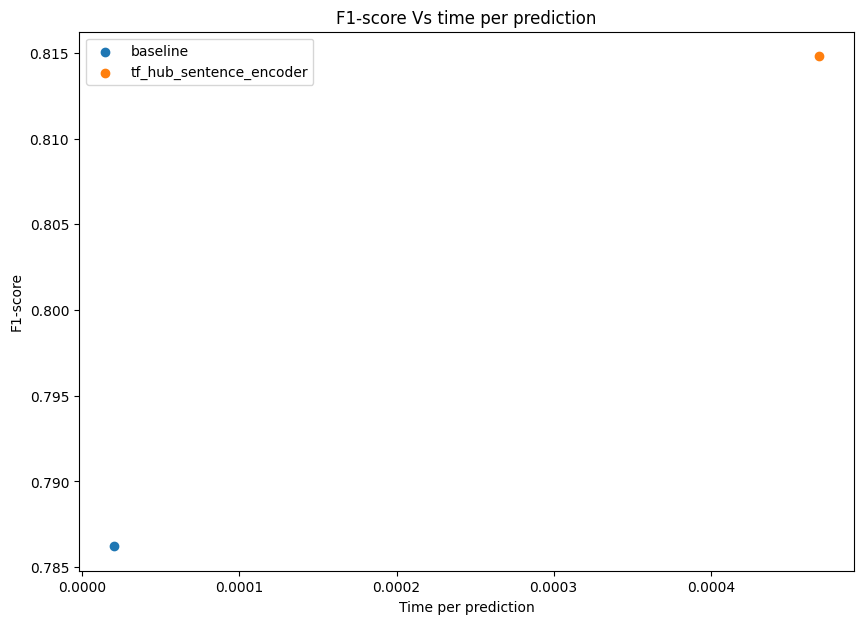

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
plt.scatter(baseline_time_per_pred, baseline_results['F1 score'], label = 'baseline')
plt.scatter(model_6_time_per_pred, model_6_pretrained_results['F1 score'], label = 'tf_hub_sentence_encoder')
plt.legend()
plt.title("F1-score Vs time per prediction")
plt.xlabel('Time per prediction')
plt.ylabel('F1-score');